TODO:
strip url column to get company names and do analysis per company
stopword cleaning and/or analysis
extract keywords for both positive and negative reviews to see top complaints and top compliments
average star rating per company
n-grams
create script for quick data cleaning


cleaning:
clean stars column into categorical
clean urls into company categories

Analysis Notes
Longer reviews are overwhelmingly negative

Further Work
Scrape newer reviews to see how they have changed in recent time
Predict rating based on comment text
If more data you could break down analysis per company to get more targeted feedback

In [1]:
# Imports 
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from collections import defaultdict
from utils import (pretty_print_row, extract_company, clean_rating, 
create_corpus, generate_ngrams, plot_ngrams)

print('Imports Complete')

Imports Complete


In [2]:
# Reading Data
df = pd.read_json('./data/train_reviews.json')
print('Data Ingested')
print(df.info())

Data Ingested
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 5 columns):
date     2021 non-null datetime64[ns, UTC]
title    2021 non-null object
text     2021 non-null object
url      2021 non-null object
stars    2021 non-null object
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 47.4+ KB
None


In [3]:
# Dropping duplicates

df = df.drop_duplicates(subset=['date', 'title', 'text', 'stars'], keep='first')
print(df.shape)

(1441, 5)


In [4]:
# def pretty_print_row(df, index: int):
#     print('Date: ' + str(df['date'].iloc[index]))
#     print('Title: ' + str(df['title'].iloc[index]))
#     print('Text: ' + str(df['text'].iloc[index]))
#     print('URL: ' + str(df['url'].iloc[index]))
#     print('Stars: ' + str(df['stars'].iloc[index]))
    
pretty_print_row(df, 0)

Date: 2015-10-10 14:32:51+00:00
Title: Bad customer service. Staff are very impolite and rude
Text: Used national rail twice and on both occasions I found the staff unpleasant, unfriendly and incompetent. Wasn't helpful in regards to platform information and general customer service skills.
URL: https://uk.trustpilot.com/review/www.nationalrail.co.uk?page=4
Stars: star-rating star-rating-1 star-rating--medium


In [5]:
# def extract_company(url: str):
#     company = url.split('/')[-1].split('?')[0]
#     return company

df['company'] = df['url'].apply(lambda x: extract_company(x))
print(df.company.value_counts())

www.virgintrains.co.uk                     480
www.southernrailway.com                    260
www.gwr.com                                180
www.eurostar.com                           180
www.virgintrainseastcoast.com              120
www.nationalrail.co.uk                      65
www.southeasternrailway.co.uk               20
www.buytickets.crosscountrytrains.co.uk     20
www.arrivatrainswales.co.uk                 20
www.tpexpress.co.uk                         20
www.eastmidlandstrains.co.uk                20
www.grandcentralrail.com                    19
www.southwesternrailway.com                 13
chilternrailways.co.uk                       8
www.londonnorthwesternrailway.co.uk          8
sleeper.scot                                 6
www.hulltrains.co.uk                         2
Name: company, dtype: int64


In [6]:
df['text_length'] = df['text'].apply(lambda x: len(x))
print(df.text_length.value_counts())


68      10
201      8
73       8
35       8
15       7
        ..
362      1
363      1
365      1
366      1
2019     1
Name: text_length, Length: 702, dtype: int64


1    1129
5     121
2     107
4      45
3      39
Name: rating, dtype: int64


<AxesSubplot:ylabel='rating'>

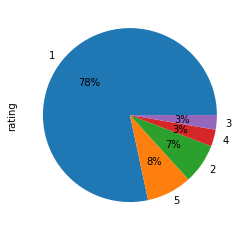

In [7]:
# def clean_rating(stars: str):
#     rating = stars.split()[1].split('-')[-1]
#     return rating

df['rating'] = df.stars.apply(lambda x: clean_rating(x)).astype('int32')
print(df.rating.value_counts())

df.rating.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [8]:
# Average rating per company
companies = df.company.unique()

print('Overall rating average: ' + str(np.asarray(df.rating).mean()))
print('Per Company:\n')
for c in companies:
    company_mean = df[df['company'] == c]['rating'].mean()
    print('Company: ' + c + '  Rating: ' + str(company_mean))



Overall rating average: 1.55794587092297
Per Company:

Company: www.nationalrail.co.uk  Rating: 1.5846153846153845
Company: sleeper.scot  Rating: 2.5
Company: www.eastmidlandstrains.co.uk  Rating: 1.4
Company: www.virgintrains.co.uk  Rating: 1.8458333333333334
Company: www.virgintrainseastcoast.com  Rating: 1.7083333333333333
Company: www.eurostar.com  Rating: 1.4444444444444444
Company: www.arrivatrainswales.co.uk  Rating: 1.7
Company: www.buytickets.crosscountrytrains.co.uk  Rating: 1.0
Company: chilternrailways.co.uk  Rating: 2.125
Company: www.southernrailway.com  Rating: 1.1961538461538461
Company: www.gwr.com  Rating: 1.3055555555555556
Company: www.grandcentralrail.com  Rating: 1.8421052631578947
Company: www.tpexpress.co.uk  Rating: 1.5
Company: www.hulltrains.co.uk  Rating: 4.5
Company: www.southwesternrailway.com  Rating: 1.0
Company: www.londonnorthwesternrailway.co.uk  Rating: 1.125
Company: www.southeasternrailway.co.uk  Rating: 1.75


<AxesSubplot:>

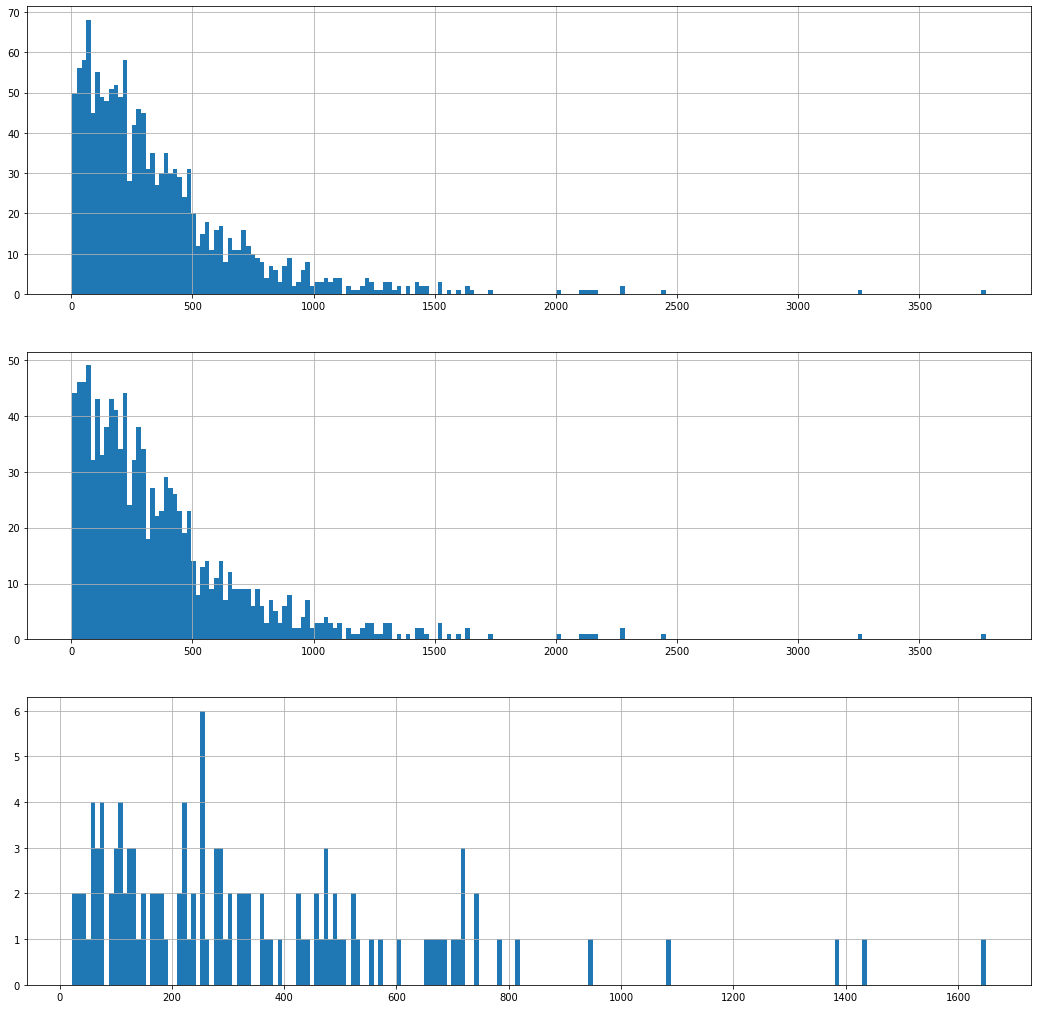

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18,18))

df['text_length'].hist(ax=ax[0], bins=200)
df[df['stars'] == 'star-rating star-rating-1 star-rating--medium']['text_length'].hist(ax=ax[1], bins=200)
df[df['stars'] == 'star-rating star-rating-5 star-rating--medium']['text_length'].hist(ax=ax[2], bins=200)
# Anomaly Detected

In [10]:
# Long comments overwhelmingly negative
print(df['rating'].mean())
print(df[df['text_length'] >= 1000]['rating'].mean())

1.55794587092297
1.2972972972972974


In [11]:
length_sorted_df = df[df['stars'] == 'star-rating star-rating-5 star-rating--medium'].sort_values(by=['text_length'], ascending=False)
pretty_print_row(length_sorted_df, 1)

Date: 2018-07-01 23:59:24+00:00
Title: Brilliant disaster preventing customer service
Text: I got onto the wrong train as I arrived at the platform at Preston station late... I got onto the train heading north to Glasgow instead of the one I needed to get onto going South towards London... I only realised when I saw that the train wasn't stopping and according to my train tracker I was meant to have already passed my stop at Wolverhampton... upon enquiry I learnt that I was indeed on the wrong train and when I consulted with the train manager I found out that the next stop was Glasgow and that would have been the last stop for the day... I didn't have enough money for anywhere to stay overnight or to get a train ticket in the morning from Glasgow... however I was delighted to find out that the extremely helpful lady, the train manager, had pulled a few strings, made a few calls and arranged for train to stop at an earlier station AND for a train going the other way to make an impromptu

10494


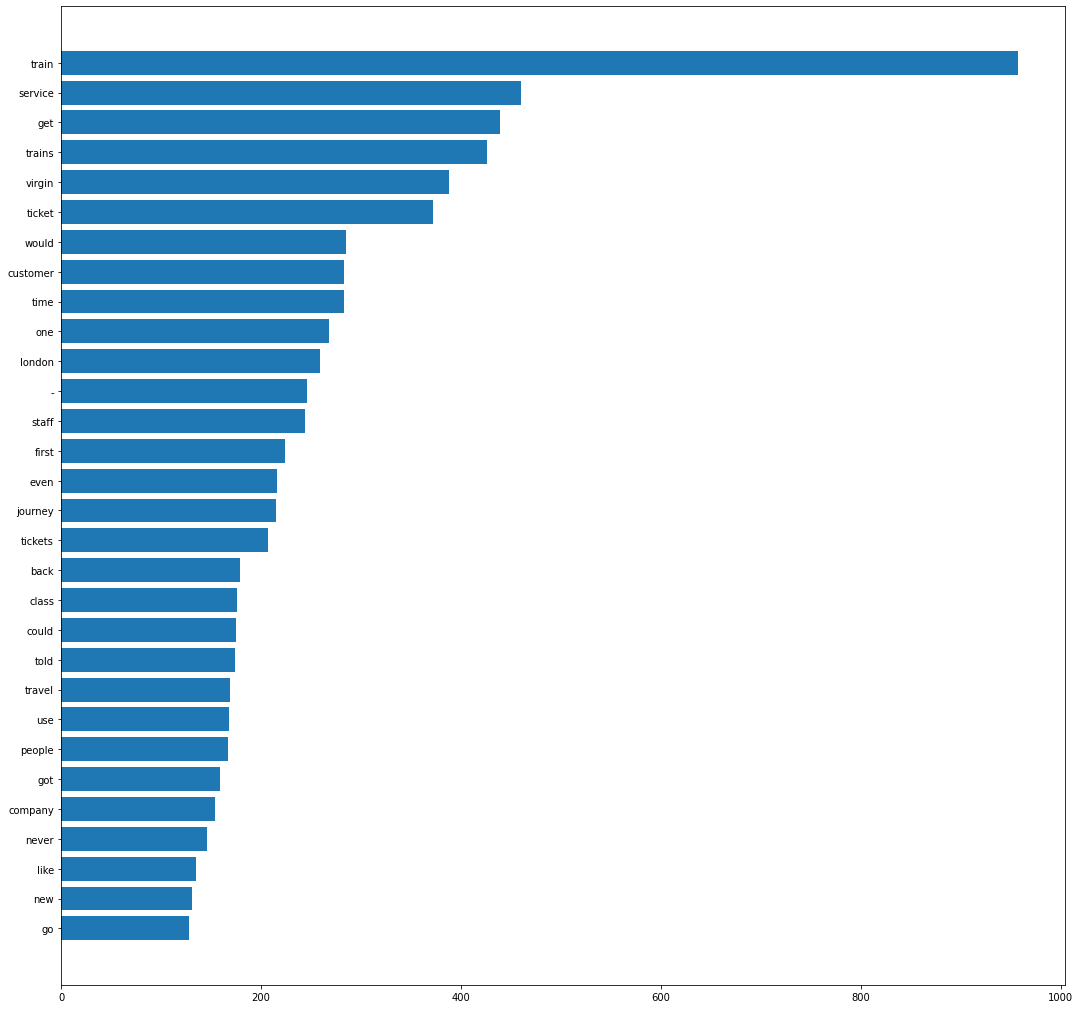

In [12]:
# Analyzing keywords
# These are most commonly used words but are pretty useless by themselves need to use bi and tri grams
# def create_corpus(df):
#     corpus = []
#     for row in df['text']:
#         for word in row.split():
#                 corpus.append(word.lower())
            
#     return corpus

corpus = create_corpus(df)
stop = set(stopwords.words('english'))

occurences = defaultdict(int)
for word in corpus:
    if word not in stop:
        occurences[word] += 1

print(len(occurences))
# print(occurences)

sorted_occurences = {k: v for k, v in sorted(occurences.items(), key=lambda item: item[1], reverse=True)}

occ_keys = list(sorted_occurences.keys())[0:30]
occ_values = list(sorted_occurences.values())[0:30]
plt.figure(figsize=(18,18))
plt.barh(y=occ_keys, width=occ_values)
plt.gca().invert_yaxis()
# plot_ngrams(df, 1, 30, (18,18))

In [13]:
# def generate_ngrams(text: str, n: int):
#     token = [token for token in text.lower().split(' ') if token != '' if token not in stop]
#     ngrams = zip(*[token[i:] for i in range(n)])
#     return [' '.join(ngram) for ngram in ngrams]


# def plot_ngrams(df, n, topn, figsize):
#     grams = defaultdict(int)
#     for comment in df['text']:
#         for gram in generate_ngrams(comment, n):
#             grams[gram] += 1

#     grams = {k: v for k, v in sorted(grams.items(), key=lambda item: item[1], reverse=True)}

#     keys = list(grams.keys())[0:topn]
#     values = list(grams.values())[0:topn]
#     plt.figure(figsize=figsize)
#     plt.barh(y=keys, width=values)
#     plt.gca().invert_yaxis()

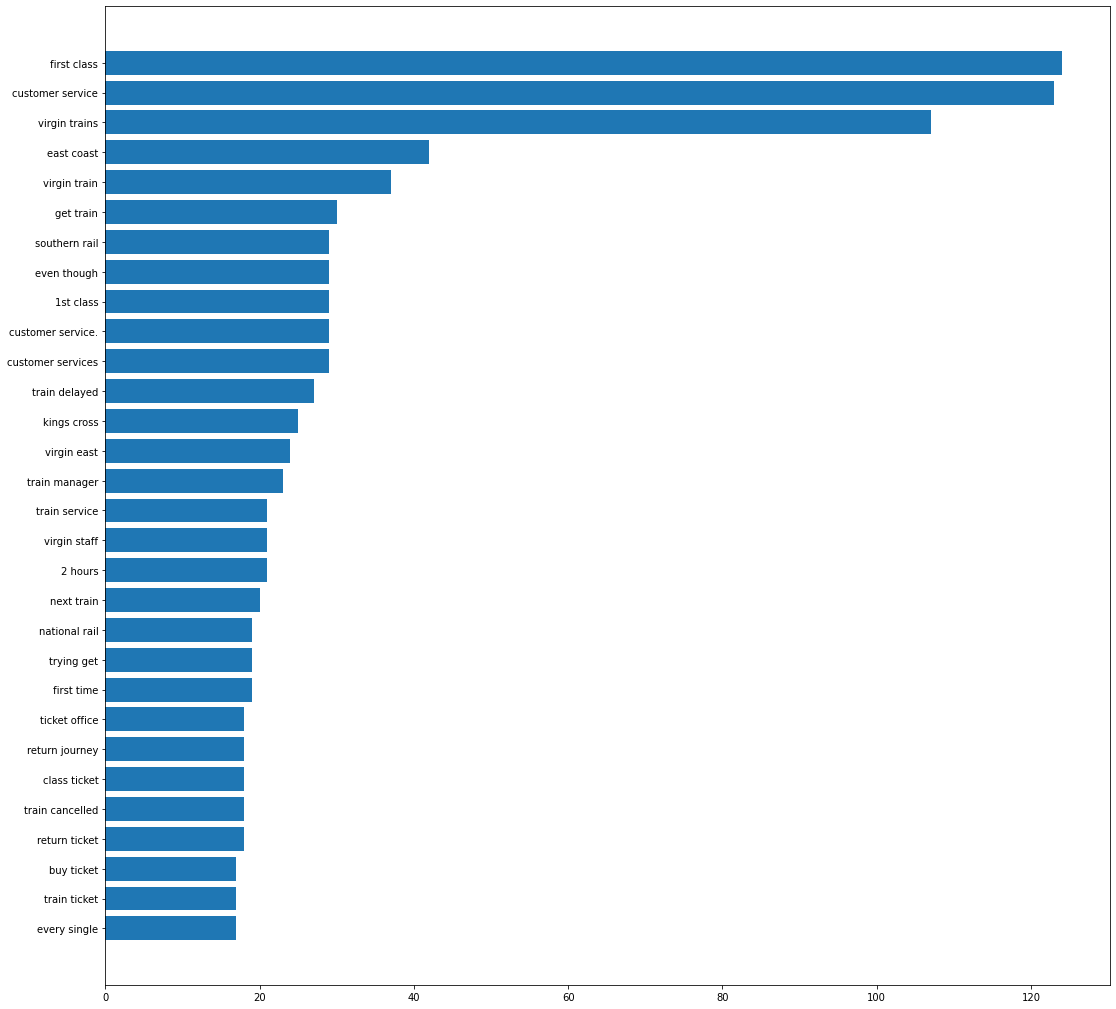

In [14]:
# Bigrams
# def plot_bigrams(df, topn, figsize):
#     bigrams = defaultdict(int)
#     for comment in df['text']:
#         for gram in generate_ngrams(comment, 2):
#             bigrams[gram] += 1

#     bigrams = {k: v for k, v in sorted(bigrams.items(), key=lambda item: item[1], reverse=True)}

#     bi_keys = list(bigrams.keys())[0:topn]
#     bi_values = list(bigrams.values())[0:topn]
#     plt.figure(figsize=figsize)
#     plt.barh(y=bi_keys, width=bi_values)
#     plt.gca().invert_yaxis()
    
plot_ngrams(df, 2, 30, (18,18))

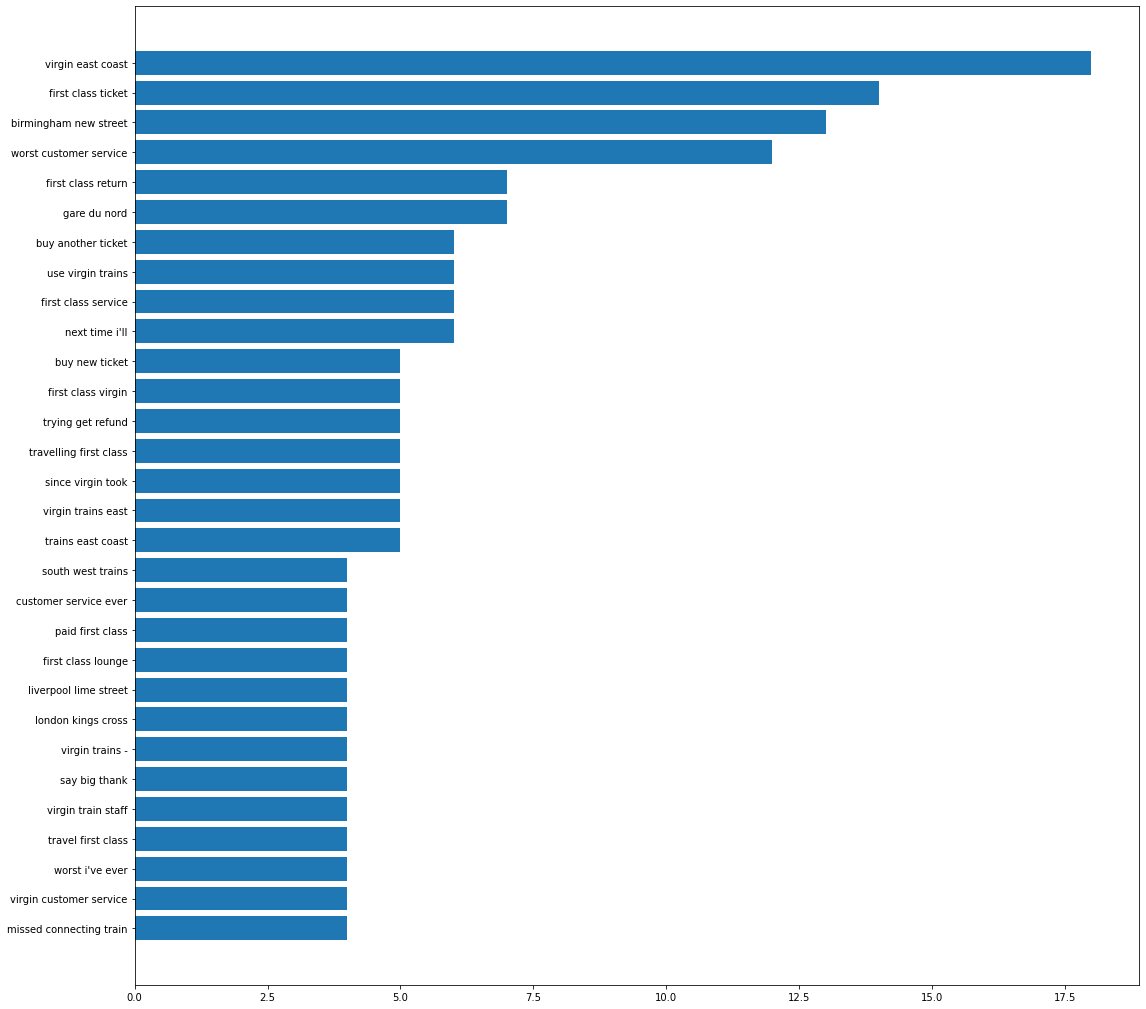

In [15]:
# Trigrams
# def plot_trigrams(df, topn, figsize):
#     trigrams = defaultdict(int)
#     for comment in df['text']:
#         for gram in generate_ngrams(comment, 3):
#             trigrams[gram] += 1

#     trigrams = {k: v for k, v in sorted(trigrams.items(), key=lambda item: item[1], reverse=True)}

#     tri_keys = list(trigrams.keys())[0:topn]
#     tri_values = list(trigrams.values())[0:topn]
#     plt.figure(figsize=figsize)
#     plt.barh(y=tri_keys, width=tri_values)
#     plt.gca().invert_yaxis()
    
plot_ngrams(df, 3, 30, (18,18))

In [16]:
# Investigating possible duplicates
# Based on spike in 5 star reviews lengths and weird behavior in trigrams 


# print(list(df[df['stars'] == 'star-rating star-rating-5 star-rating--medium'].sort_values(by=['text_length'], ascending=False)['text_length']))

anomalies = df[df['stars'] == 'star-rating star-rating-5 star-rating--medium']
anomalies = anomalies[df['text_length'] == 259]

# for i in range(anomalies.shape[0]):
#     pretty_print_row(anomalies, i)
    
da_df = df[df['title'] == 'Disabled assistance']
print(da_df.shape)
print(anomalies.shape)

# 1 star review duplicates
one_star_anomalies = df[df['stars'] == 'star-rating star-rating-1 star-rating--medium']

# one_star_anomalies = df[df['text_length'] >= 1000]
# print(list(one_star_anomalies.sort_values(by=['text_length'], ascending=False)['text_length']))

one_star_anomalies = df[df['text_length'] == 1153]

print(one_star_anomalies['date'].iloc[0])
# print(list(one_star_anomalies.shape))

# for i in range(one_star_anomalies.shape[0]):
#     pretty_print_row(one_star_anomalies, i)
# This explains the weird trigram behavior

# Drop duplicates?

(1, 8)
(1, 8)
2018-07-11 08:41:10+00:00


<ipython-input-16-9bc04228e79a>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anomalies = anomalies[df['text_length'] == 259]


In [17]:
# Exploring duplicates more

# print(list(df.date.value_counts()))
# date_df = pd.DataFrame(df.date.value_counts(), columns=['date', 'd_count'])
# print(date_df)

# df['date_count'] = df.groupby(['date'])['text'].transform('count')
# print(df[df['date_count'] == 21].shape)

duplicated_df = df[df.duplicated(subset=['date', 'title', 'text', 'stars'], keep='first') == True]
print(duplicated_df.date.value_counts())
print(duplicated_df.shape)

single_date_df = df[df['date'] == '2018-04-16 14:33:59+00:00']
print(single_date_df.shape)
for i in range(single_date_df.shape[0]):
    pretty_print_row(single_date_df, i)
    

clean_df = df.drop_duplicates(subset=['date', 'title', 'text', 'stars'], keep='first')
print(df.shape)
print(clean_df.shape)

Series([], Name: date, dtype: int64)
(0, 8)
(1, 8)
Date: 2018-04-16 14:33:59+00:00
Title: Amazing
Text: Amazing! Marcus Garvey super helpful and efficient! Thank you so much for dealing with my case so effectively!
URL: https://uk.trustpilot.com/review/www.virgintrainseastcoast.com?page=1
Stars: star-rating star-rating-5 star-rating--medium
(1441, 8)
(1441, 8)


2015-10-10 14:32:51+00:00
2017    548
2018    536
2016    287
2015     68
2011      2
Name: year, dtype: int64


<AxesSubplot:>

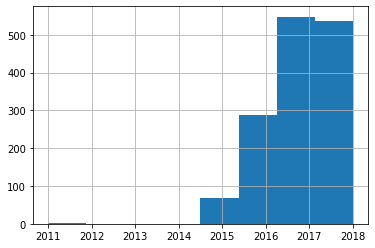

In [18]:
# Start looking at data based on time(positive/negative ratings over time)
print(df['date'].iloc[0])

# print(df.info())
# df['datetime'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S+%f'))

# print(df.sort_values(by=['date'], ascending=False))
df['year'] = df['date'].apply(lambda x: x.year)
print(df['year'].value_counts())
df['year'].hist(bins=8)

c:\users\wilso\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\wilso\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\wilso\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not lay

<AxesSubplot:xlabel='year'>

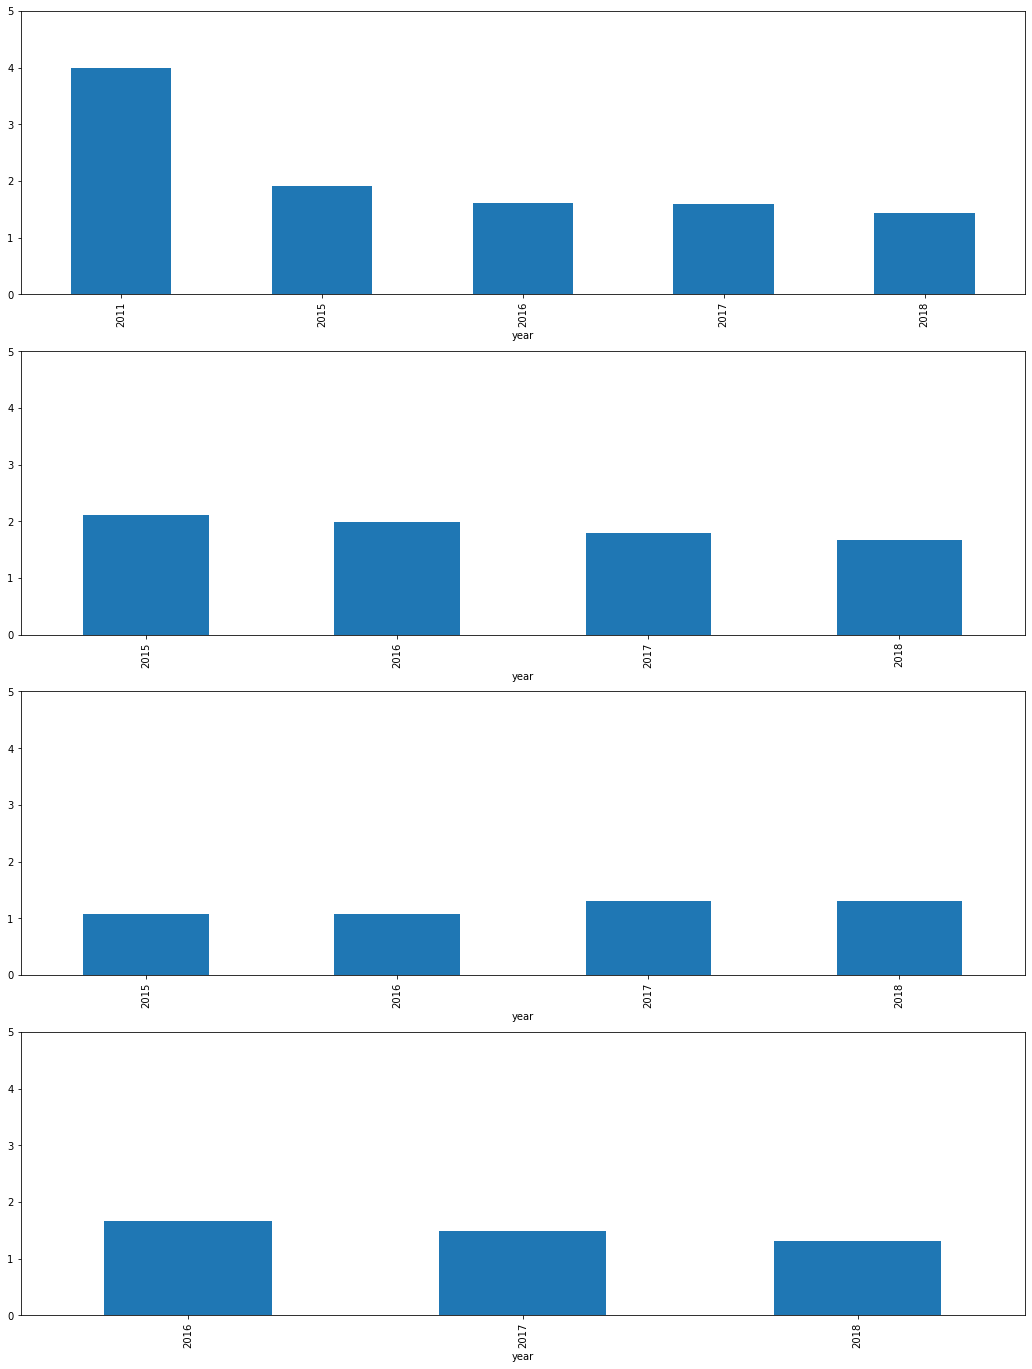

In [19]:
# Average rating per year
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(18,24))
for a in ax:
    a.set_ylim([0,5])
    
df.groupby('year')['rating'].mean().plot(kind='bar', ax=ax[0])
df[df['company'] == 'www.virgintrains.co.uk'].groupby('year')['rating'].mean().plot(kind='bar', ax=ax[1])
df[df['company'] == 'www.southernrailway.com'].groupby('year')['rating'].mean().plot(kind='bar', ax=ax[2])
df[df['company'] == 'www.eurostar.com'].groupby('year')['rating'].mean().plot(kind='bar', ax=ax[3])

Plotting topics(ngrams) over time

%

%

%

%

(68, 9)


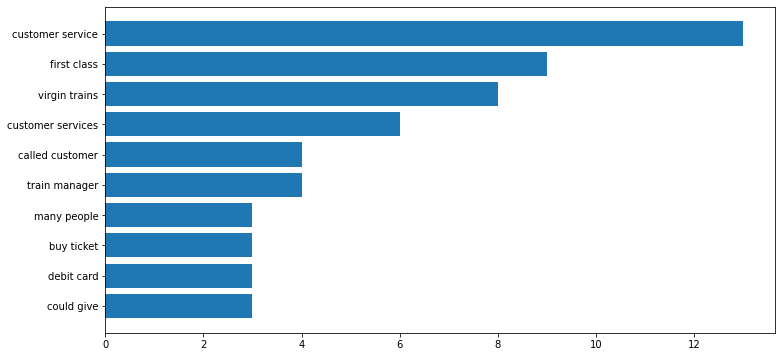

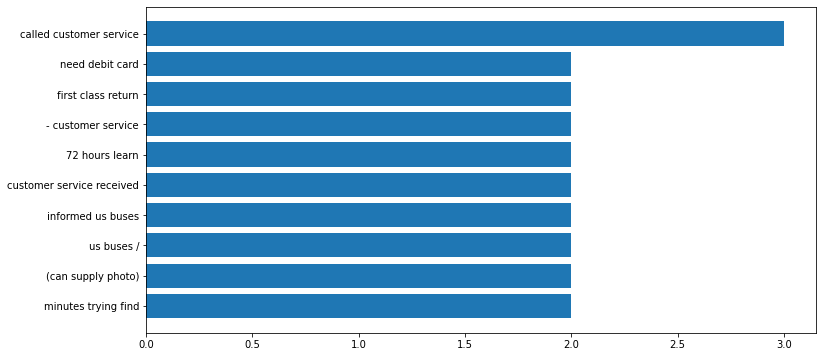

In [20]:
# Plotting bigrams in different years to see changes over time :: 2015

print(df[df['year'] == 2015].shape)
plot_ngrams(df[df['year'] == 2015], 2, 10, (12, 6))
plot_ngrams(df[df['year'] == 2015], 3, 10, (12, 6))

(287, 9)


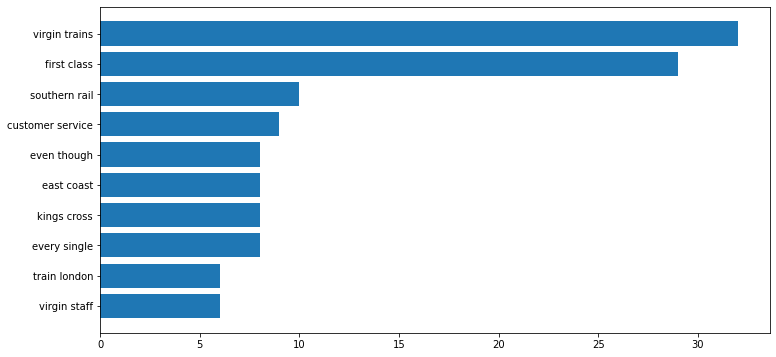

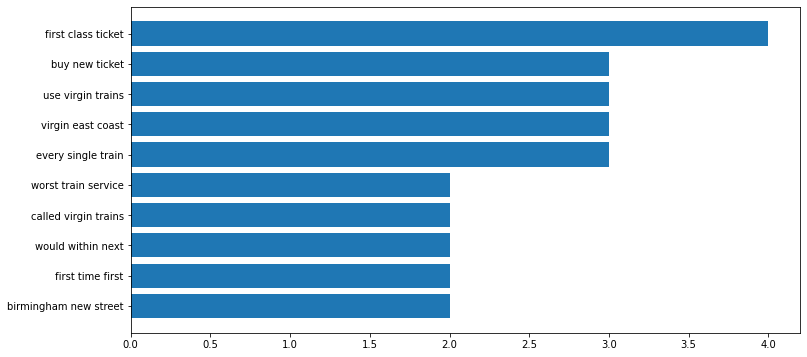

In [21]:
# 2016
print(df[df['year'] == 2016].shape)
plot_ngrams(df[df['year'] == 2016], 2, 10, (12, 6))
plot_ngrams(df[df['year'] == 2016], 3, 10, (12, 6))

(548, 9)


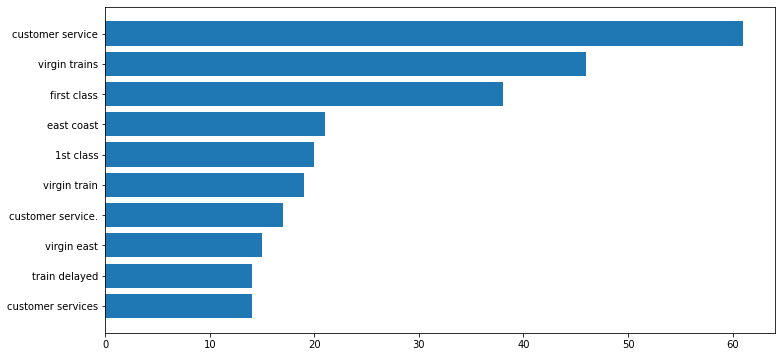

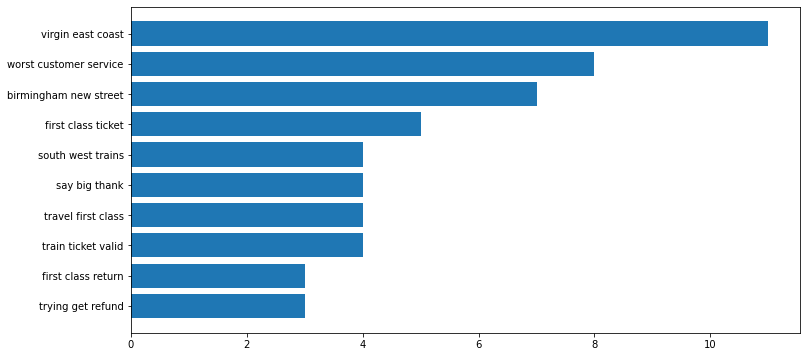

In [22]:
# 2017
print(df[df['year'] == 2017].shape)
plot_ngrams(df[df['year'] == 2017], 2, 10, (12, 6))
plot_ngrams(df[df['year'] == 2017], 3, 10, (12, 6))

(536, 9)


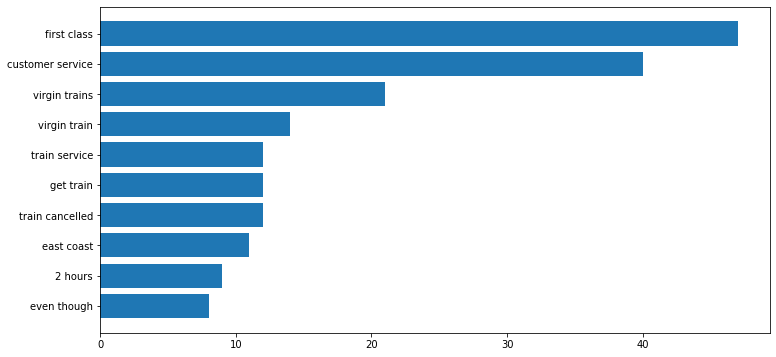

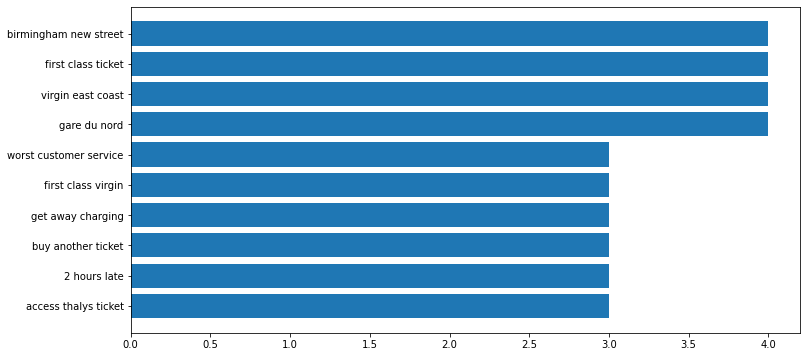

In [23]:
# 2018
print(df[df['year'] == 2018].shape)
plot_ngrams(df[df['year'] == 2018], 2, 10, (12, 6))
plot_ngrams(df[df['year'] == 2018], 3, 10, (12, 6))

Plotting topics(ngrams) in positive vs negative

%

%

%

%

(166, 9)


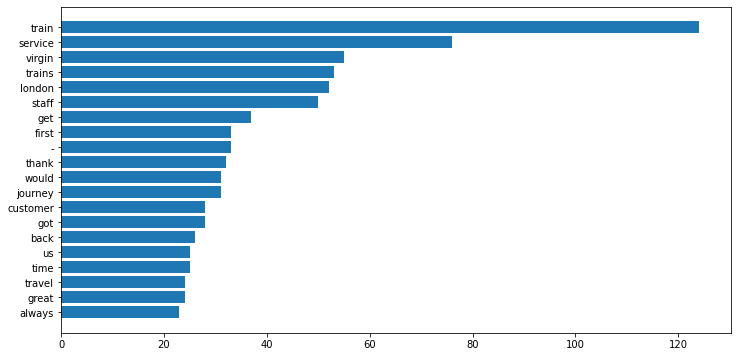

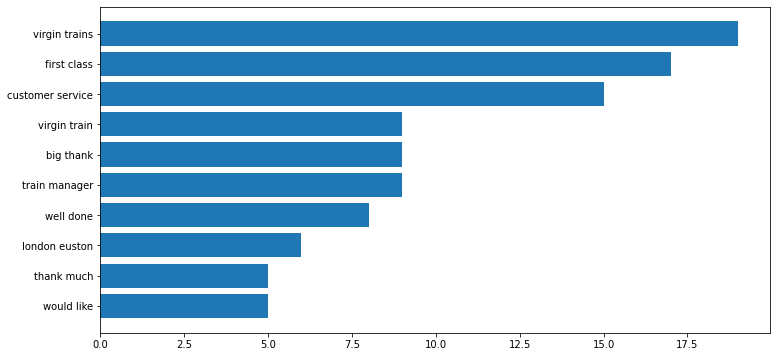

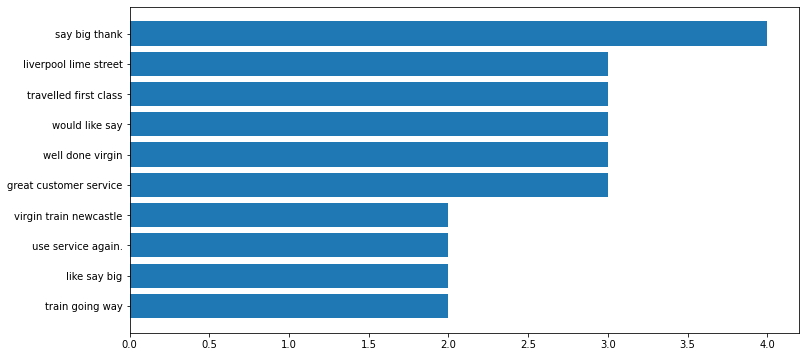

In [24]:
# Postive ngrams
positive_df = df[(df['rating'] == 5) | (df['rating'] == 4)]
print(positive_df.shape)
plot_ngrams(positive_df, 1, 20, (12, 6))
plot_ngrams(positive_df, 2, 10, (12, 6))
plot_ngrams(positive_df, 3, 10, (12, 6))

(1236, 9)


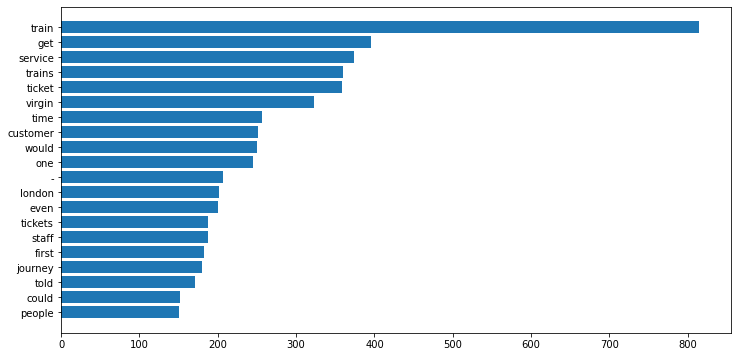

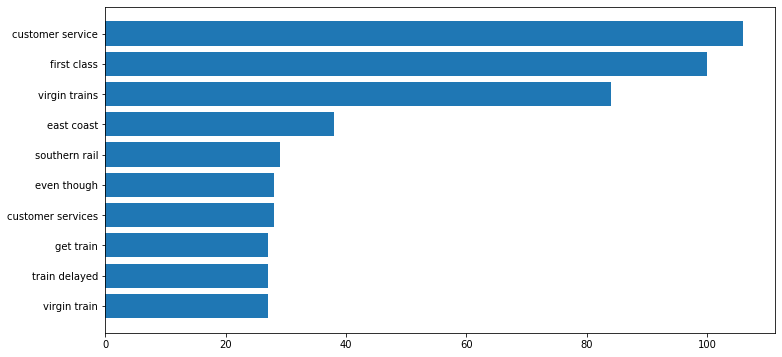

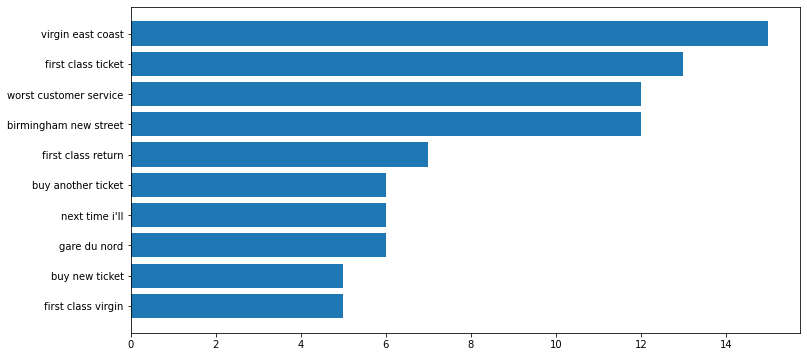

In [25]:
# Negative ngrams
negative_df = df[(df['rating'] == 1) | (df['rating'] == 2)]
print(negative_df.shape)
plot_ngrams(negative_df, 1, 20, (12, 6))
plot_ngrams(negative_df, 2, 10, (12, 6))
plot_ngrams(negative_df, 3, 10, (12, 6))

Plotting topics(ngrams) per company(Top 4 ~ 80% of data)

%

%

%

%

(480, 9)


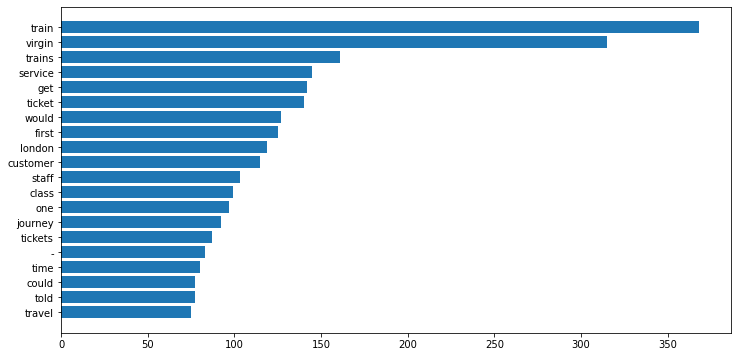

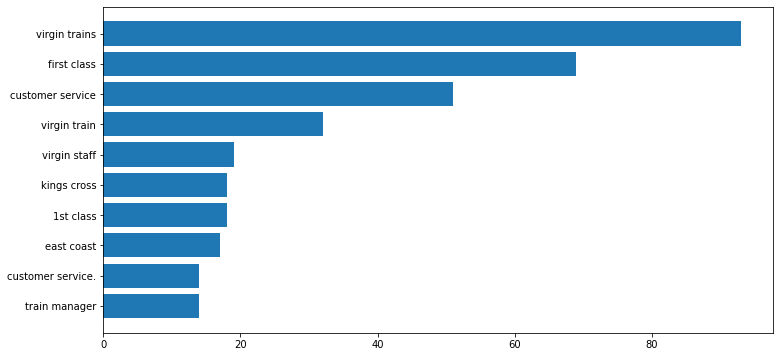

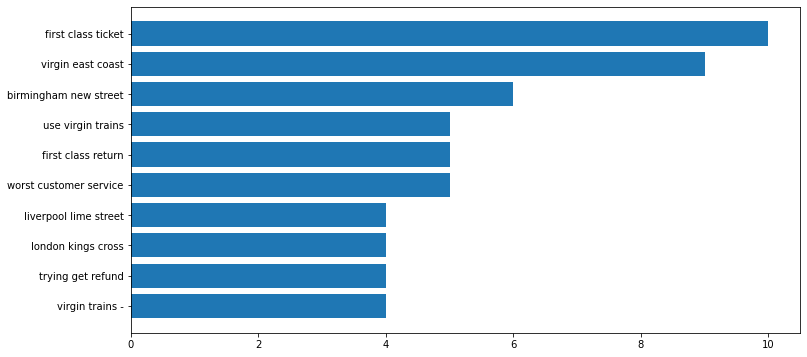

In [26]:
company_df = df[df['company'] == 'www.virgintrains.co.uk']
print(company_df.shape)
plot_ngrams(company_df, 1, 20, (12, 6))
plot_ngrams(company_df, 2, 10, (12, 6))
plot_ngrams(company_df, 3, 10, (12, 6))

(260, 9)


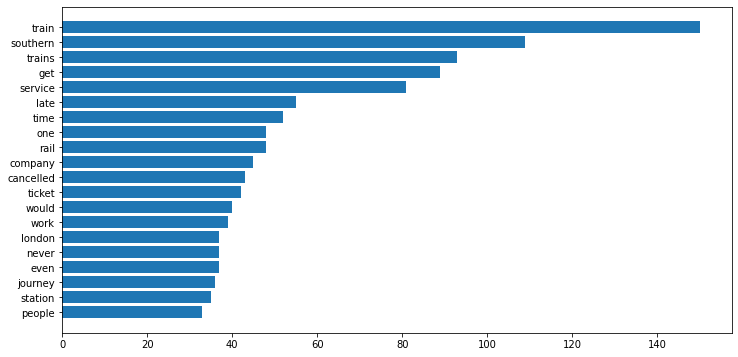

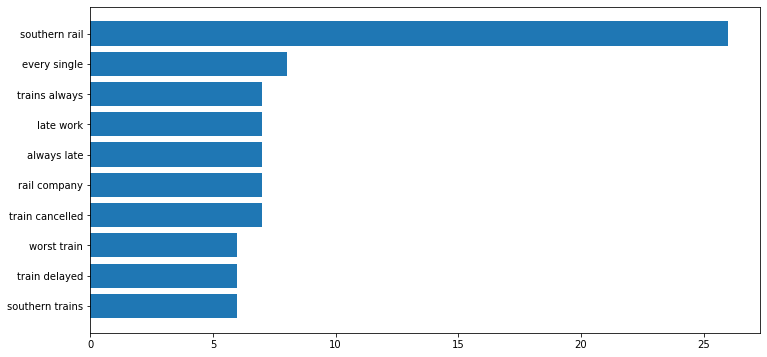

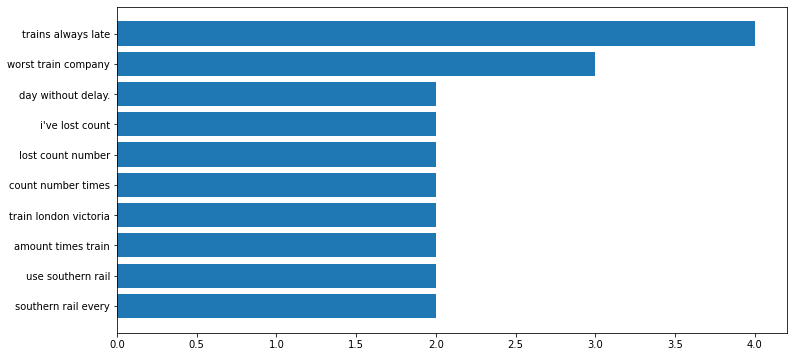

In [27]:
company_df = df[df['company'] == 'www.southernrailway.com']
print(company_df.shape)
plot_ngrams(company_df, 1, 20, (12, 6))
plot_ngrams(company_df, 2, 10, (12, 6))
plot_ngrams(company_df, 3, 10, (12, 6))

(180, 9)


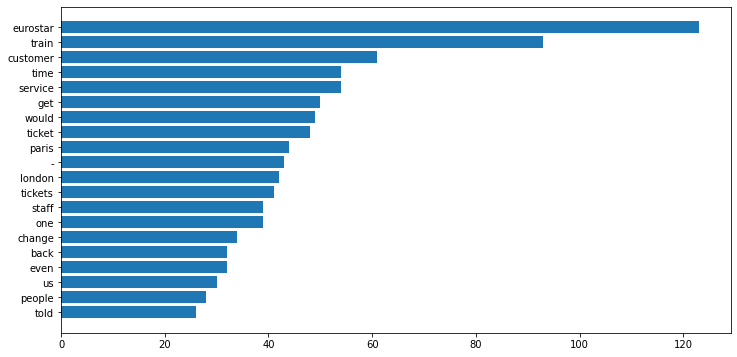

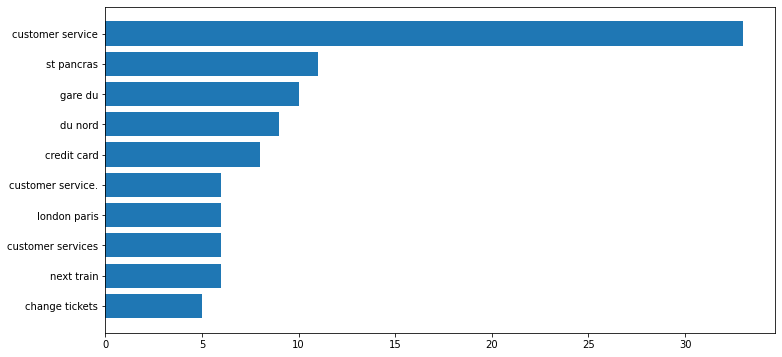

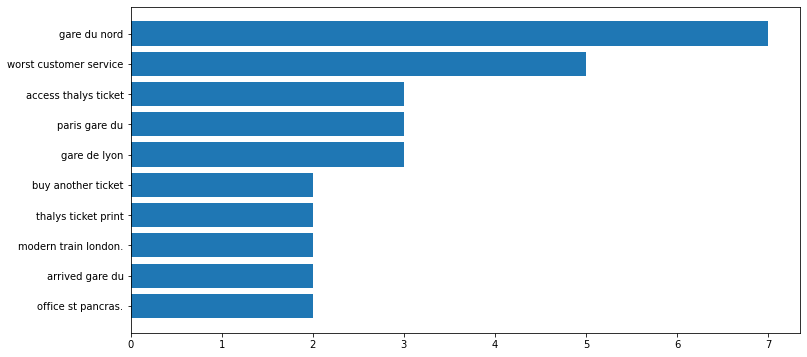

In [28]:
company_df = df[df['company'] == 'www.eurostar.com']
print(company_df.shape)
plot_ngrams(company_df, 1, 20, (12, 6))
plot_ngrams(company_df, 2, 10, (12, 6))
plot_ngrams(company_df, 3, 10, (12, 6))

(180, 9)


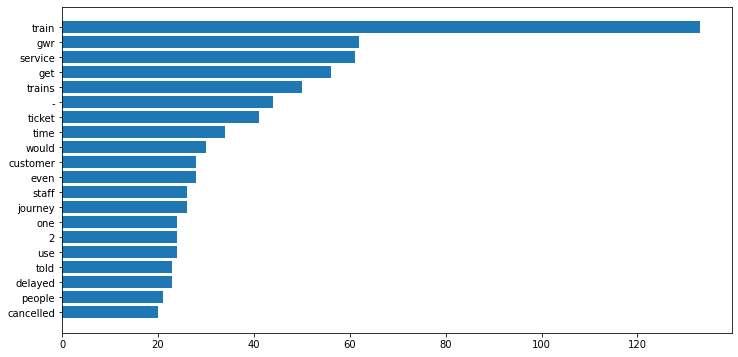

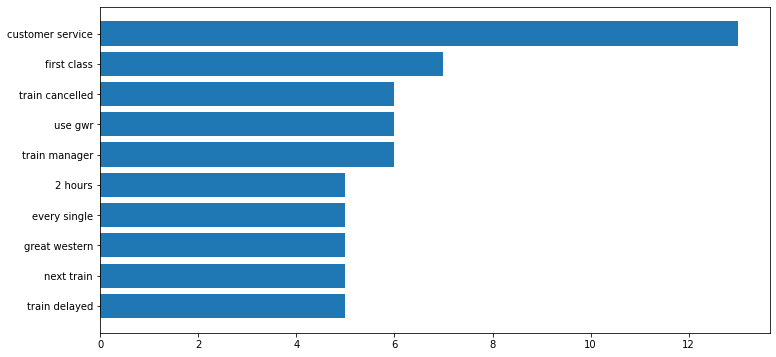

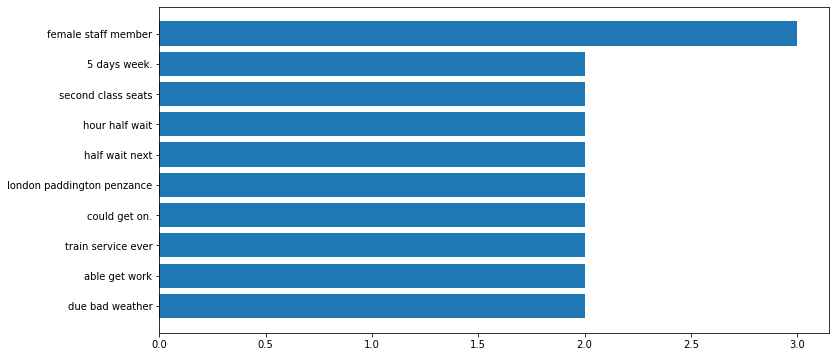

In [29]:
company_df = df[df['company'] == 'www.gwr.com']
print(company_df.shape)
plot_ngrams(company_df, 1, 20, (12, 6))
plot_ngrams(company_df, 2, 10, (12, 6))
plot_ngrams(company_df, 3, 10, (12, 6))